In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import sys

import icomo

sys.path.append("../src/")
from tapm import model_STI
from tapm import sti_infection_results_LambdaP
from tapm import utils

In [2]:
args, y0 = utils.read_params(filename="model_params_HIVandSTI.txt")

In [3]:
# functions we need

def Nobs(P,H):
    return lambdas(P,H)*Is(P,H) + lambdaa(P,H)*Ia(P,H)

def Nreal(P,H):
    return args['beta_STI']*((1-m(P,H))*(1-P)+P) * S(P,H) * (Is(P,H)+Ia(P,H))

def Is(P,H):
    return b(P,H)/a(P,H) * (1-args['psi'])/args['psi'] * Ia(P,H)

def Ia(P,H):
    return ((args['mu']+args['gammaT_STI']) * (1/R0(P,H) - 1)) / (-b(P,H)/args['psi'] + args['gamma_STI'] + args['gammaT_STI']*(1 + b(P,H)/a(P,H)*(1-args['psi'])/args['psi']))

def S(P,H):
    return a(P,H)/((1-args['psi'])*alpha(P,H)) * Is(P,H)/(Ia(P,H) + Is(P,H))

def lambdas(P,H):
    return args['lambda_s'] + lambdaa(P,H)

def lambdaa(P,H):
    return lambdaH(P,H) * (1-P) + args['lambda_P'] * P

def lambdaH(P,H):
    return c()*(1-m(P,H))*betaHIV(P,H)*H

def betaHIV(P,H):
    return args['beta_HIV'] * (1-m(P,H))

def m(P,H):
    return args['min_exp'] + (args['max_exp'] - args['min_exp']) * (1 - np.exp(-H/args['tau_exp']))

def a(P,H):
    return lambdas(P,H) + args['mu']

def b(P,H):
    return args['gamma_STI'] + lambdaa(P,H) + args['mu']

def R0(P,H):
    return args['psi']*alpha(P,H)/b(P,H) + (1-args['psi'])*alpha(P,H)/a(P,H)

def alpha(P,H):
    return args['beta_STI'] * (1 - m(P,H)*(1 - P))

def c():
    return args['c']

In [4]:
# derivatives of functions
# dx/dy names dx_dy for easier readability

def dNobs_dP(P,H):
    return Is(P,H)*dlambdas_dP(P,H) + Ia(P,H)*dlambdaa_dP(P,H) + lambdas(P,H)*dIs_dP(P,H) + lambdaa(P,H)*dIa_dP(P,H)

def dNobs_dH(P,H):
    return Is(P,H)*dlambdas_dH(P,H) + Ia(P,H)*dlambdaa_dH(P,H) + lambdas(P,H)*dIs_dH(P,H) + lambdaa(P,H)*dIa_dH(P,H)

def dNreal_dP(P,H):
    return args['beta_STI']*S(P,H)*(((1-m(P,H))*(1-P)+P)*(dIs_dP(P,H)+dIa_dP(P,H)) + (Is(P,H)+Ia(P,H))*(-(1-m(P,H))+1)) + Nreal(P,H)/S(P,H)*dS_dP(P,H)

def dNreal_dH(P,H):
    return args['beta_STI']*S(P,H)*(((1-m(P,H))*(1-P)+P)*(dIs_dH(P,H)+dIa_dH(P,H)) + (Is(P,H)+Ia(P,H))*((1-P)*(-dm_dH(P,H)))) + Nreal(P,H)/S(P,H)*dS_dH(P,H)

def dIs_dP(P,H):
    return 1/a(P,H)*(1-args['psi'])/args['psi']*Ia(P,H)*db_dP(P,H) + b(P,H)*(1-args['psi'])/args['psi']*Ia(P,H)*(-1/a(P,H)**2)*da_dP(P,H) + b(P,H)/a(P,H)*(1-args['psi'])/args['psi']*dIa_dP(P,H)

def dIs_dH(P,H):
    return 1/a(P,H)*(1-args['psi'])/args['psi']*Ia(P,H)*db_dH(P,H) + b(P,H)*(1-args['psi'])/args['psi']*Ia(P,H)*(-1/a(P,H)**2)*da_dH(P,H) + b(P,H)/a(P,H)*(1-args['psi'])/args['psi']*dIa_dH(P,H)

def dIa_dP(P,H):
    part1 = (args['mu']+args['gammaT_STI'])/(-b(P,H)/args['psi'] + args['gamma_STI'] - args['gammaT_STI']*(1+b(P,H)/a(P,H)*(1-args['psi'])/args['psi'])) * (-1/R0(P,H))*dR0_dP(P,H)
    part2 = ((args['mu']+args['gammaT_STI'])*(1/R0(P,H)-1))/(-(b(P,H)/args['psi'] + args['gamma_STI'] + args['gammaT_STI']*(1+b(P,H)/a(P,H)*(1-args['psi'])/args['psi']))**2) * (-1/args['psi']*db_dP(P,H) - args['gammaT_STI']/a(P,H)*(1-args['psi'])/args['psi']*db_dP(P,H) + args['gammaT_STI']*b(P,H)/(a(P,H))**2*(1-args['psi'])/args['psi']*da_dP(P,H))
    return part1 + part2

def dIa_dH(P,H):
    part1 = (args['mu']+args['gammaT_STI'])/(-b(P,H)/args['psi'] + args['gamma_STI'] - args['gammaT_STI']*(1+b(P,H)/a(P,H)*(1-args['psi'])/args['psi'])) * (-1/R0(P,H))*dR0_dH(P,H)
    part2 = ((args['mu']+args['gammaT_STI'])*(1/R0(P,H)-1))/(-(b(P,H)/args['psi'] + args['gamma_STI'] + args['gammaT_STI']*(1+b(P,H)/a(P,H)*(1-args['psi'])/args['psi']))**2) * (-1/args['psi']*db_dH(P,H) - args['gammaT_STI']/a(P,H)*(1-args['psi'])/args['psi']*db_dH(P,H) + args['gammaT_STI']*b(P,H)/(a(P,H))**2*(1-args['psi'])/args['psi']*da_dH(P,H))
    return part1 + part2

def dS_dP(P,H):
    part1 = 1/((1-args['psi'])*alpha(P,H)) * Is(P,H)/(Ia(P,H)+Is(P,H)) * da_dP(P,H)
    part2 = a(P,H)/((1-args['psi'])*alpha(P,H)) * 1/(Ia(P,H)+Is(P,H)) * dIs_dP(P,H)
    part3 = a(P,H)/((1-args['psi'])*alpha(P,H)) * Is(P,H) * (-1/(Ia(P,H)+Is(P,H))**2) * (dIa_dP(P,H) + dIs_dP(P,H))
    part4 = a(P,H)/(-(1-args['psi'])*(alpha(P,H))**2) * Is(P,H)/(Ia(P,H)+Is(P,H)) * dalpha_dP(P,H)
    return part1 + part2 + part3 + part4

def dS_dH(P,H):
    part1 = 1/((1-args['psi'])*alpha(P,H)) * Is(P,H)/(Ia(P,H)+Is(P,H)) * da_dH(P,H)
    part2 = a(P,H)/((1-args['psi'])*alpha(P,H)) * 1/(Ia(P,H)+Is(P,H)) * dIs_dH(P,H)
    part3 = a(P,H)/((1-args['psi'])*alpha(P,H)) * Is(P,H) * (-1/(Ia(P,H)+Is(P,H))**2) * (dIa_dH(P,H) + dIs_dH(P,H))
    part4 = a(P,H)/(-(1-args['psi'])*(alpha(P,H))**2) * Is(P,H)/(Ia(P,H)+Is(P,H)) * dalpha_dH(P,H)
    return part1 + part2 + part3 + part4

def da_dP(P,H):
    return dlambdas_dP(P,H)

def da_dH(P,H):
    return dlambdas_dH(P,H)

def db_dP(P,H):
    return dlambdaa_dP(P,H)

def db_dH(P,H):
    return dlambdaa_dH(P,H)

def dR0_dP(P,H):
    return args['psi']*alpha(P,H)*(-1/(b(P,H))**2)*db_dP(P,H) + (1-args['psi'])*alpha(P,H)*(-1/(a(P,H))**2)*da_dP(P,H) + (args['psi']/b(P,H) + (1-args['psi'])/a(P,H))*dalpha_dP(P,H)

def dR0_dH(P,H):
    return args['psi']*alpha(P,H)*(-1/(b(P,H))**2)*db_dH(P,H) + (1-args['psi'])*alpha(P,H)*(-1/(a(P,H))**2)*da_dH(P,H) + (args['psi']/b(P,H) + (1-args['psi'])/a(P,H))*dalpha_dH(P,H)

def dalpha_dP(P,H):
    return args['beta_STI']*m(P,H)

def dalpha_dH(P,H):
    return -args['beta_sTI']*(1-P)*dm_dH(P,H)

def dlambdas_dP(P,H):
    return dlambdaa_dP(P,H)

def dlambdas_dH(P,H):
    return dlambdaa_dH(P,H)

def dlambdaa_dP(P,H):
    return -lambdaH(P,H) + args['lambda_P']

def dlambdaa_dH(P,H):
    return (1-P)*dlambdaH_dH(P,H)

def dlambdaH_dP(P,H):
    return 0

def dlambdaH_dH(P,H):
    return c()*(1-m(P,H))*betaHIV(P,H) + c()*(1-m(P,H))*H*dbetaHIV_dH(P,H) - c()*betaHIV(P,H)*H*dm_dH(P,H)

def dbetaHIV_dP(P,H):
    return 0

def dbetaHIV_dH(P,H):
    return -args['beta_HIV']*dm_dH(P,H)

def dm_dP(P,H):
    return 0

def dm_dH(P,H):
    return (args['max_exp'] - args['min_exp'])/args['tau_exp'] * np.exp(-H/args['tau_exp'])





In [5]:
Ps = np.linspace(0,100,100)
Hs = np.linspace(0,20,100)

dNobs = np.zeros((len(Ps),len(Hs)))
dNreal = np.zeros((len(Ps),len(Hs)))
dNobs_signs = np.zeros((len(Ps),len(Hs)))
dNreal_signs = np.zeros((len(Ps),len(Hs)))
dNobs_dNreal_comparison = np.zeros((len(Ps),len(Hs)))

for i,P in enumerate(Ps):
    for j,H in enumerate(Hs):
        dNobs[i,j] = dNobs_dP(P,H)
        dNreal[i,j] = dNreal_dP(P,H)
        dNobs_signs[i,j] = np.sign(dNobs[i,j])
        dNreal_signs[i,j] = np.sign(dNreal[i,j])
        dNobs_dNreal_comparison[i,j] = np.sign(dNobs[i,j]) + np.sign(dNreal[i,j])





/tmp/ipykernel_19924/184487845.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return ((args['mu']+args['gammaT_STI']) * (1/R0(P,H) - 1)) / (-b(P,H)/args['psi'] + args['gamma_STI'] + args['gammaT_STI']*(1 + b(P,H)/a(P,H)*(1-args['psi'])/args['psi']))
/tmp/ipykernel_19924/1356535989.py:17: RuntimeWarning: invalid value encountered in scalar add
  return 1/a(P,H)*(1-args['psi'])/args['psi']*Ia(P,H)*db_dP(P,H) + b(P,H)*(1-args['psi'])/args['psi']*Ia(P,H)*(-1/a(P,H)**2)*da_dP(P,H) + b(P,H)/a(P,H)*(1-args['psi'])/args['psi']*dIa_dP(P,H)
/tmp/ipykernel_19924/1356535989.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  part1 = (args['mu']+args['gammaT_STI'])/(-b(P,H)/args['psi'] + args['gamma_STI'] - args['gammaT_STI']*(1+b(P,H)/a(P,H)*(1-args['psi'])/args['psi'])) * (-1/R0(P,H))*dR0_dP(P,H)
/tmp/ipykernel_19924/1356535989.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  part2 = ((args['mu']+args['gammaT_STI'])*(1/R0(P,H)-1))/(-(b(P,

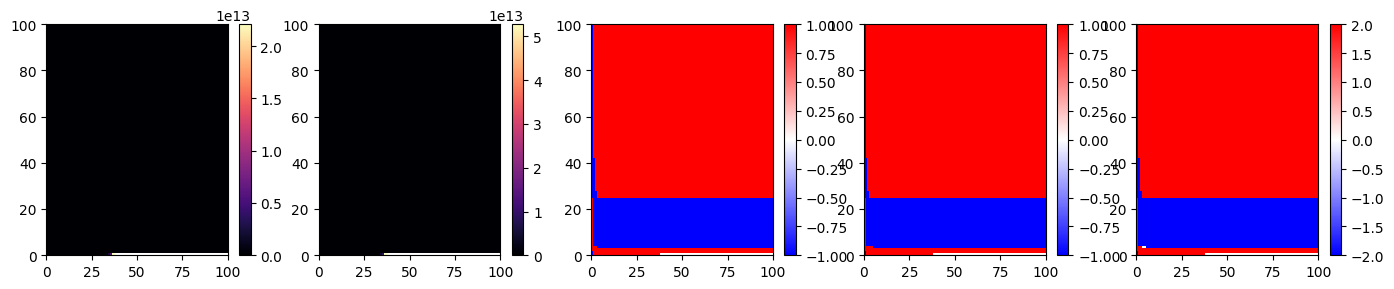

In [9]:

plots = [dNobs, dNreal, dNobs_signs, dNreal_signs, dNobs_dNreal_comparison]
fig, axs = plt.subplots(1,5,figsize=(17,3))
cmaps = ['magma', 'magma', 'bwr', 'bwr', 'bwr']
for i,col in enumerate(cmaps):
    ax = axs[i]
    pcm = ax.pcolormesh(plots[i],
                        cmap=col)
    fig.colorbar(pcm, ax=axs[i], shrink=1)
